In [1]:
try:
  import google.colab
  RUNNING_ON_COLAB= True
except:
  RUNNING_ON_COLAB= False

if RUNNING_ON_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [2]:
!ls

data					      Feature_eng.ipynb
diabetes_012_health_indicators_BRFSS2015.csv  mlruns
experimentation.ipynb			      plots
exploration_basic.ipynb			      SVM_model.ipynb


In [3]:
import os 

In [4]:
USER = os.environ.get('USER')
print(f'Current user: {USER}')

Current user: slavoj


In [5]:
PATH = 'data/diabetes_012_health_indicators_BRFSS2015.csv'

In [78]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

import lightgbm
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import umap 

from sklearn.metrics import mean_absolute_error, mean_squared_error, matthews_corrcoef, accuracy_score, f1_score
from sklearn.metrics import classification_report


import multiprocessing
import time
import mlflow

In [7]:
data = pd.read_csv(PATH)

In [17]:
X, Y = data.drop("Diabetes_012", axis = 1), data['Diabetes_012']

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 20)

In [8]:
client = mlflow.tracking.MlflowClient()

In [9]:
mlflow.tracking.get_tracking_uri()

'file:///home/slavoj/Desktop/hnnaharendt/diabetes-prediction/Diabetes_prediction/mlruns'

In [10]:
mlflow.sklearn.autolog()
mlflow.lightgbm.autolog()
mlflow.xgboost.autolog()

2022/01/08 15:24:09 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


In [32]:
def custom_logging(y_true, y_pred, verbose = 1):
    mcc = matthews_corrcoef(y_true = y_true, y_pred = y_pred)
    mse = mean_squared_error(y_true = y_true, y_pred = y_pred)
    mae = mean_absolute_error(y_true = y_true, y_pred = y_pred)
    acc = accuracy_score(y_true = y_true, y_pred = y_pred)
    f1 = f1_score(y_true = y_true, y_pred = y_pred, average='weighted')

    mlflow.log_metric(key = 'acc_', value = acc)
    mlflow.log_metric(key = 'mae_', value = mae)
    mlflow.log_metric(key = 'mse_', value = mse)
    mlflow.log_metric(key = 'f1_', value = f1)
    mlflow.log_metric(key = 'mcc_', value = mcc)

    if verbose:
        print(classification_report(y_true, y_pred, target_names=['0', '1', '2']))
        print(f"MAE: \t{mae}")
        print(f"MSE: \t{mse}")
        print(f"ACC: \t{acc}")
        print(f"MCC: \t{mcc}")

In [14]:
mlflow.create_experiment('Tree-based methods')

'1'

#### Models w/ default params, no additional feature

In [26]:
with mlflow.start_run(run_name = "DT, default_params, no features", experiment_id = 1) as run:
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, Y_train)
    Y_preds = decision_tree.predict(X_test)
    custom_logging(Y_test, Y_preds)



2022/01/08 18:04:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.88      0.86      0.87     42753
           1       0.03      0.04      0.04       927
           2       0.30      0.32      0.31      7056

    accuracy                           0.77     50736
   macro avg       0.40      0.41      0.40     50736
weighted avg       0.78      0.77      0.77     50736

MAE: 	0.42086486912645854
MSE: 	0.801620151371807
ACC: 	0.7695127719962157
MCC: 	0.18429470140408055


In [33]:
with mlflow.start_run(run_name = "RF, default_params, no features", experiment_id = 1) as run:
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, Y_train)
    Y_preds = rf_model.predict(X_test)
    custom_logging(Y_test, Y_preds)

2022/01/08 18:48:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.02      0.00      0.00       927
           2       0.46      0.19      0.27      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.39     50736
weighted avg       0.79      0.84      0.81     50736

MAE: 	0.3010091453800063
MSE: 	0.5829391359192684
ACC: 	0.8399558498896247
MCC: 	0.22113168136271447


In [28]:
with mlflow.start_run(run_name = "XGB, default_params, no features", experiment_id = 1) as run:
    xgb_model = xgboost.XGBClassifier()
    xgb_model.fit(X_train, Y_train)
    Y_preds = xgb_model.predict(X_test)
    custom_logging(Y_test, Y_preds)

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.54      0.19      0.28      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28482734153263956
MSE: 	0.551383632923368
ACC: 	0.8484508041627247
MCC: 	0.25221772604933373


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [34]:
with mlflow.start_run(run_name = "LGBM, default_params, no features", experiment_id = 1) as run:
    lgb_model = lightgbm.LGBMClassifier()
    lgb_model.fit(X_train, Y_train)
    Y_preds = lgb_model.predict(X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.2835856196783349
MSE: 	0.5488804793440555
ACC: 	0.8490618101545254
MCC: 	0.24923258027101233


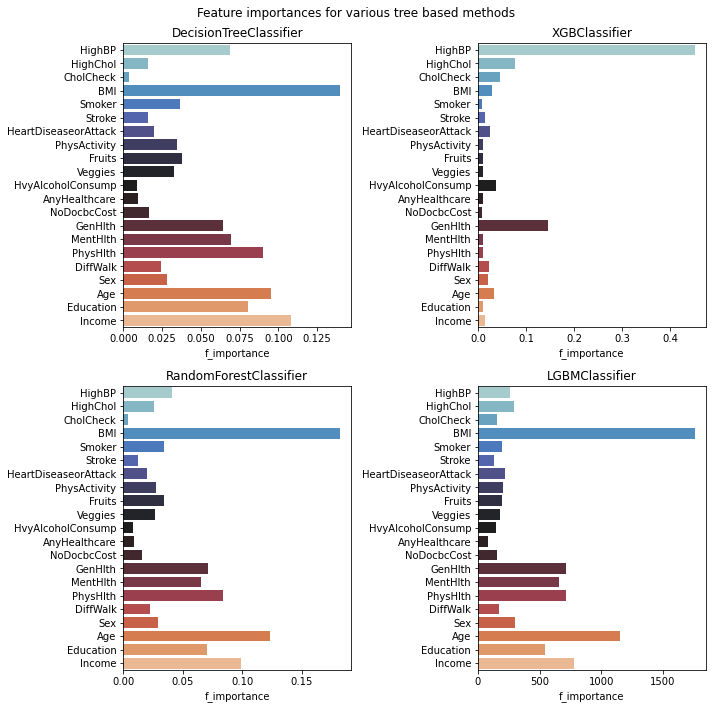

In [87]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
features = X_train.columns
i, j = 0, 0
for model in [decision_tree, rf_model, xgb_model, lgb_model]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = features,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot(y = fi_subset.index, x = fi_subset.f_importance,
    order = features, ax = axs[i][j],
    palette = 'icefire'
    ).set_title(f"{type(model).__name__}")
 
    i += 1

plt.suptitle("Feature importances for various tree based methods")   
plt.tight_layout()
plt.savefig("plots/fi_basic")
plt.show()



### Exploring dimensionality reduction 

#### PCA

In [35]:
dim_reduction = PCA(n_components = 10)
dim_reduced_X_train = dim_reduction.fit_transform(X_train)
dim_reduced_X_test = dim_reduction.transform(X_test)

2022/01/08 18:57:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3a31cf0945a84d398ed2e6dc92a6e248', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/01/08 18:57:36 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/01/08 18:57:36 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature


In [36]:

with mlflow.start_run(run_name = "DT, pca = 10", experiment_id = 1) as run:
    decision_tree_pca = DecisionTreeClassifier()
    decision_tree_pca.fit(dim_reduced_X_train, Y_train)
    Y_preds = decision_tree_pca.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

2022/01/08 19:03:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.87      0.87      0.87     42753
           1       0.02      0.03      0.03       927
           2       0.28      0.29      0.29      7056

    accuracy                           0.77     50736
   macro avg       0.39      0.39      0.39     50736
weighted avg       0.77      0.77      0.77     50736

MAE: 	0.4187756228319142
MSE: 	0.8010288552507095
ACC: 	0.7723509933774835
MCC: 	0.1658455555307739


In [37]:

with mlflow.start_run(run_name = "RF, pca = 10", experiment_id = 1) as run:
    rf_pca = RandomForestClassifier()
    rf_pca.fit(dim_reduced_X_train, Y_train)
    Y_preds = rf_pca.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

2022/01/08 19:04:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.03      0.00      0.00       927
           2       0.47      0.16      0.24      7056

    accuracy                           0.84     50736
   macro avg       0.45      0.38      0.39     50736
weighted avg       0.79      0.84      0.80     50736

MAE: 	0.2997477136549984
MSE: 	0.5804951119520656
ACC: 	0.8406259854935352
MCC: 	0.205613877494482


In [38]:

with mlflow.start_run(run_name = "XGB, pca = 10", experiment_id = 1) as run:
    xgb_pca = xgboost.XGBClassifier()
    xgb_pca.fit(dim_reduced_X_train, Y_train)
    Y_preds = xgb_pca.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.52      0.18      0.26      7056

    accuracy                           0.85     50736
   macro avg       0.46      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.2886313465783664
MSE: 	0.5589719331441185
ACC: 	0.8465389467045096
MCC: 	0.2376376456024916


In [39]:

with mlflow.start_run(run_name = "LGBM, pca = 10", experiment_id = 1) as run:
    lgbm_pca = lightgbm.LGBMClassifier()
    lgbm_pca.fit(dim_reduced_X_train, Y_train)
    Y_preds = lgbm_pca.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.53      0.16      0.25      7056

    accuracy                           0.85     50736
   macro avg       0.46      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28809918006937874
MSE: 	0.5579273099968464
ACC: 	0.8468148848943551
MCC: 	0.23152148881331808


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

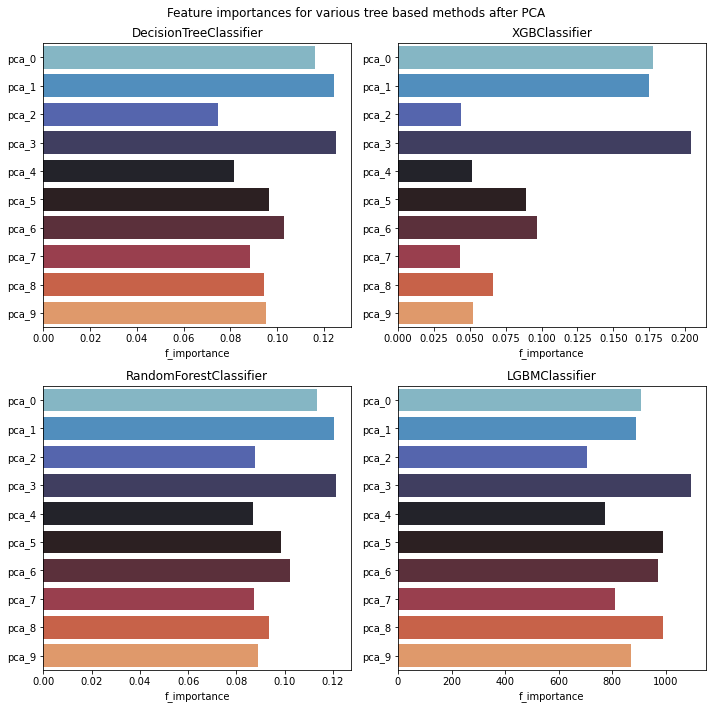

In [88]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
dim_features = pd.DataFrame(dim_reduced_X_train)
dim_features.columns = ["pca_" + str(i) for i in range(len(dim_features.columns))]

i, j = 0, 0
for model in [decision_tree_pca, rf_pca, xgb_pca, lgbm_pca]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = dim_features.columns,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot( y = fi_subset.index, x = fi_subset.f_importance,
            ax = axs[i][j],order = dim_features.columns,
            palette = 'icefire').set_title(f"{type(model).__name__}")
 
    i += 1

plt.suptitle("Feature importances for various tree based methods after PCA")   
plt.tight_layout()
plt.savefig("plots/fi_pca")
plt.show()

#### UMAP

In [79]:
#### PCA
dim_reduction = umap.UMAP(n_components = 10)
dim_reduced_X_train = dim_reduction.fit_transform(X_train)
dim_reduced_X_test = dim_reduction.transform(X_test)



/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [80]:
with mlflow.start_run(run_name = "DT, umap = 10", experiment_id = 1) as run:
    decision_tree_umap = DecisionTreeClassifier()
    decision_tree_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = decision_tree_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)



2022/01/08 20:09:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.87      0.85      0.86     42753
           1       0.03      0.04      0.03       927
           2       0.25      0.27      0.26      7056

    accuracy                           0.76     50736
   macro avg       0.38      0.39      0.38     50736
weighted avg       0.77      0.76      0.76     50736

MAE: 	0.44782797224850207
MSE: 	0.8569260485651214
ACC: 	0.7567210659098076
MCC: 	0.13224867876462681


In [81]:
with mlflow.start_run(run_name = "RF, umap = 10", experiment_id = 1) as run:
    rf_umap = RandomForestClassifier()
    rf_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = rf_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)



2022/01/08 20:11:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."


              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.03      0.00      0.00       927
           2       0.40      0.14      0.21      7056

    accuracy                           0.83     50736
   macro avg       0.43      0.37      0.37     50736
weighted avg       0.78      0.83      0.79     50736

MAE: 	0.3138008514664144
MSE: 	0.6087787764112268
ACC: 	0.8336881110059918
MCC: 	0.1648261211735937


In [82]:
with mlflow.start_run(run_name = "XGB, umap = 10", experiment_id = 1) as run:
    xgb_umap = xgboost.XGBClassifier()
    xgb_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = xgb_pca.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)



/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:11:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     42753
           1       0.02      0.01      0.02       927
           2       0.07      0.01      0.02      7056

    accuracy                           0.81     50736
   macro avg       0.31      0.33      0.31     50736
weighted avg       0.72      0.81      0.76     50736

MAE: 	0.34594765058341215
MSE: 	0.6653658152002523
ACC: 	0.8137614317250079
MCC: 	-0.028119012719161254


In [83]:
with mlflow.start_run(run_name = "LGBM, umap = 10", experiment_id = 1) as run:
    lgbm_umap = lightgbm.LGBMClassifier()
    lgbm_umap.fit(dim_reduced_X_train, Y_train)
    Y_preds = lgbm_umap.predict(dim_reduced_X_test)
    custom_logging(Y_test, Y_preds)

              precision    recall  f1-score   support

           0       0.85      1.00      0.91     42753
           1       0.00      0.00      0.00       927
           2       0.55      0.03      0.05      7056

    accuracy                           0.84     50736
   macro avg       0.46      0.34      0.32     50736
weighted avg       0.79      0.84      0.78     50736

MAE: 	0.29452459791863767
MSE: 	0.5707781456953642
ACC: 	0.8436021759697256
MCC: 	0.09696603699771505


/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slavoj/mambaforge/envs/experimental_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

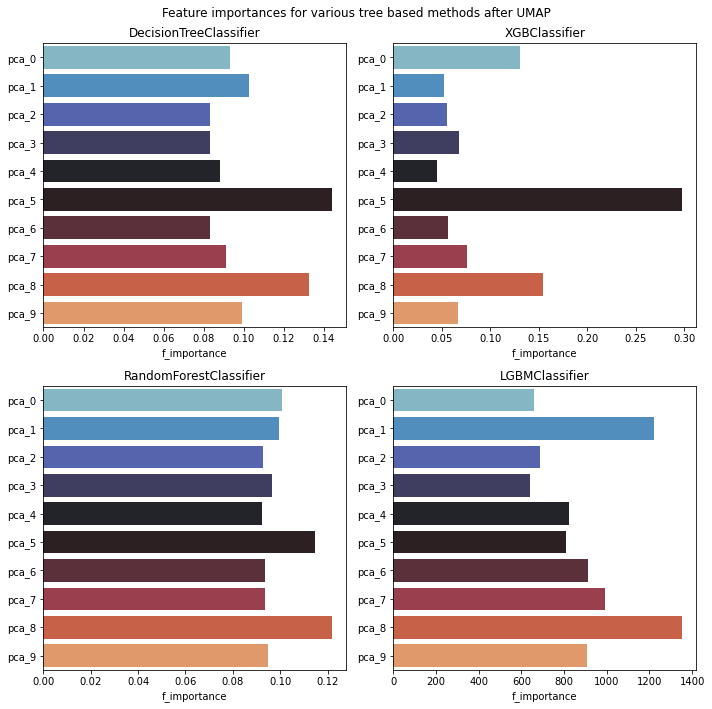

In [89]:
fig, axs = plt.subplots(nrows= 2, ncols = 2, figsize = (10,10))
dim_features = pd.DataFrame(dim_reduced_X_train)
dim_features.columns = ["pca_" + str(i) for i in range(len(dim_features.columns))]

i, j = 0, 0
for model in [decision_tree_umap, rf_umap, xgb_umap, lgbm_umap]:
    if i == 2:
        i = 0
        j = 1
    fi_subset = pd.DataFrame(model.feature_importances_, index = dim_features.columns,
            columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
    
    sns.barplot( y = fi_subset.index, x = fi_subset.f_importance,
            ax = axs[i][j],order = dim_features.columns,
            palette = 'icefire').set_title(f"{type(model).__name__}")
 
    i += 1
    
plt.suptitle("Feature importances for various tree based methods after UMAP")   
plt.tight_layout()
plt.savefig("plots/fi_umap")
plt.show()